# Evaluation for both traditional and neural retrieval -  TEST set only (shown in report)

In [1]:
import pandas as pd
from google.colab import drive
import numpy as np
!pip3 install pickle5
import pickle5 as pickle
import os
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 133kB 3.3MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219266 sha256=1a07a6b29cbda95cbcf432d4aa11f09fd35b576a20acc13a4756964710f4ffbc
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [2]:
drive.mount('/content/drive', force_remount=True)  # use force_remount=True param after upload of new data
# !ls "/content/drive/My Drive/Master/2 - FSS 2021/Information Retrieval/IR Projekt/"

Mounted at /content/drive


### Prep

In [3]:
# file and folder names
#ir_project_drive_folder = "Master/2 - FSS 2021/Information Retrieval/IR Projekt"  # TODO: geht das für alle?
ir_project_drive_folder = "IR Projekt"  # TODO: geht das für alle?
full_ir_project_drive_folder = "/content/drive/My Drive/{}/data/wikipedia".format(ir_project_drive_folder)

# full_ir_project_drive_folder = '../data/wikipedia'
raw_folder = full_ir_project_drive_folder + '/raw'
preprocessed_folder = full_ir_project_drive_folder + '/no-pron/preprocessed'
bm25_folder = full_ir_project_drive_folder + '/no-pron/bm25'

# raw qa filenames
qa_wikipedia_test_without_answers_filename = raw_folder + '/qa/wikipedia-test-without-answers.json'

## evidence documents
wikipedia_evidence_file = raw_folder + '/wikipedia_evidence_dict.pkl'

# preprocessed evidence files
wikipedia_evidence_file = raw_folder + '/wikipedia_evidence_dict.pkl'
preprocessed_wikipedia_evidence_file = preprocessed_folder + '/preprocessed_wikipedia_evidence_dict.pkl'

# preprocessed qa files
preprocessed_qa_wikipedia_test_without_answers_filename = preprocessed_folder + '/qa/wikipedia-test-without-answers.pkl'

# BM25 retrieval
bm25_retrieval_wiki_test_docs_scores = full_ir_project_drive_folder + "/no-pron/bm25/retrieval_wiki_test_docs_scores.pkl"
bm25_retrieved_docs_TP_FP = full_ir_project_drive_folder + "/Neural_Reranking_Test/bm25_tp_fp.pkl"

# VSM retrieval
vsm_retrieval_wiki_test_docs_scores = full_ir_project_drive_folder + "/no-pron/vsm/retrieval_wiki_test_docs_scores.pkl"

## ready for retrieval
retrieval_ready_qa_wiki_test = preprocessed_folder + '/qa/retrieval_ready_qa_wiki_test.pkl'

## reranked
bm25_rr_100_roberta_5000_15000_wd_1 = full_ir_project_drive_folder + '/Neural_Reranking_Test/RoBERTa/First_5000_15000.pkl'
bm25_rr_100_roberta_5000_15000_wd_2_rh = full_ir_project_drive_folder + '/Neural_Reranking_Test/RoBERTa/Second_5000_15000_randhard.pkl'

In [4]:
def save_as_pickle(obj, filename):
    """
    save an object in a pickle file dump
    :param obj: object to dump
    :param filename: target file
    :return:
    """
    directory = os.path.dirname(filename)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    with open(filename, 'wb') as file:
        pickle.dump(obj, file, protocol=pickle.HIGHEST_PROTOCOL)


def load_pickle(filename):
    """
    load an object from a given pickle file
    :param filename: source file
    :return: loaded object
    """
    with open(filename, 'rb') as file:
        return pickle.load(file)

## Load Data

In [5]:
# Query Data: Wiki Test Set(Preprocessed)
retrieval_ready_qa_wiki_test_dict = load_pickle(os.path.join(full_ir_project_drive_folder, retrieval_ready_qa_wiki_test))


## Evaluation

Precision = tp / (tp + fp) \\
Recall = tp / (tp + fn) \
MAP = 1/ # of queries * Sum over queries (AP)

In [6]:
## number of retrieved docs (tp + fp)
def number_of_retrieved_docs(query_results, output):
  for key in query_results:
    output[key] = {"TP+FP": len(query_results[key])}

In [7]:
## Calculate number of true positive retrievals - PREP FOR NEURAL RETRIEVAL
def true_pos_NN(query_dict, query_results, output, query_dict_forNN):
  for key in query_results:
    query_dict_forNN[key]={'matching_documents':[]}
    query_dict_forNN[key]["false positive document"] = []
    true_pos = 0
    true_available = len(query_dict[key]["matching_documents"])
    output[key]["TP+FN"]=true_available
    found = len(query_results[key])
    for i in range(true_available):
      for j in range(found):
        if query_dict[key]["matching_documents"][i] == query_results[key][j][0]:
          true_pos +=1
          query_dict_forNN[key]['matching_documents'].append(query_dict[key]["matching_documents"][i])
        else: 
          query_dict_forNN[key]["false positive document"].append(query_results[key][j][0])
          j +=1
      i +=1
    output[key]["TP"]=true_pos

In [8]:
## Calculate number of true positive retrievals - EVALUATION ONLY
def true_pos(query_dict, query_results, output):
  for key in query_results:
    true_pos = 0
    true_available = len(query_dict[key]["matching_documents"])
    output[key]["TP+FN"]=true_available
    found = len(query_results[key])
    for i in range(true_available):
      for j in range(found):
        if query_dict[key]["matching_documents"][i] == query_results[key][j][0]:
          true_pos +=1
        else: j +=1
      i +=1
    output[key]["TP"]=true_pos

In [9]:
def precision_recall(evaluation):
  for key in evaluation:
    if evaluation[key]['TP+FP'] > 0:
      evaluation[key]["Precision"]=evaluation[key]['TP']/evaluation[key]['TP+FP']
    else:
      evaluation[key]["Precision"]=0
    
    if evaluation[key]['TP+FN'] >0:
      evaluation[key]["Recall"]=evaluation[key]['TP']/evaluation[key]['TP+FN']
    else:evaluation[key]["Recall"]=0


In [10]:
# Average Precision
def MAP(query_dict, query_results, output, map_unnorm, MAP):
  # map_unnorm = 0
  # MAP = 0
  counter=0
  for q_id, documents in (query_results.items()):
    ap = 0
    pos = 0
    correct=0
    doc_list = query_dict[q_id]['matching_documents'] 
    for j in range(len(documents)):
      pos +=1
      if documents[j][0] in doc_list:
        correct +=1
        ap += correct/pos
        if pos == 1:
          counter +=1
    if output[q_id]["TP+FN"] >0:
      output[q_id]["AP"] = ap / output[q_id]["TP+FN"]
      map_unnorm+= ap / output[q_id]["TP+FN"]
    else:
      output[q_id]["AP"] = 0
      map_unnorm+= 0

  MAP= map_unnorm/len(query_results)
  print(f"")
  print(f"MAP: {MAP}")
  print(f"For {counter} queries, a correct document was retrieved at rank 1, Precision @Rank 1 = ({round(counter*100/len(query_results),2)} %)")


In [11]:
## Check how many queries could not be answered
def check_perf(evaluation):
  not_found = 0

  for key in evaluation:
    if evaluation[key]["TP"]==0:
      not_found +=1

  print(f"For {len(evaluation)-not_found} queries out of {len(evaluation)} at least 1 correct document was retrieved ({round((len(evaluation)-not_found)*100/len(evaluation),2)} %)")

In [12]:
def APhistogram(input, AP):
  for key in input:
    AP.append(input[key]["AP"])
  plt.hist(AP,range=[0,1])
  plt.show()

In [13]:
def ComboHist(AP_1, AP_2):
  plt.hist(AP_1,range=[0,1], bins=20, histtype='step', label='AP VSM')
  plt.hist(AP_2,  bins=20,histtype='step', ls='--',label='AP BM25')
  plt.legend(loc='upper left')
  plt.show()

In [14]:
def TripleHist(AP_1, AP_2, AP_3):
  plt.hist(AP_1,range=[0,1], bins=20, histtype='step', label='AP BM25')
  plt.hist(AP_2,  bins=20,histtype='step', ls='--',label='AP RoBERTa 1:3')
  plt.hist(AP_3,  bins=20,histtype='step',label='AP RoBERTa 1:3 & Random FP')
  plt.legend(loc='upper left')
  plt.show()

# Traditional retrieval


In [ ]:
# Retrieved Documents: Wiki Test Set(Preprocessed)
bm25_retrieval_wiki_test_docs_scores_dict = load_pickle(os.path.join(full_ir_project_drive_folder, bm25_retrieval_wiki_test_docs_scores))

# Retrieved Documents: Wiki Test Set(Preprocessed)
vsm_retrieval_wiki_test_docs_scores_dict = load_pickle(os.path.join(full_ir_project_drive_folder, vsm_retrieval_wiki_test_docs_scores))

### Test Set Prep

In [ ]:
def rerank_topX(retrieved, X, topX):
  for query, list_ret in retrieved.items():
    topX[query] = list_ret[:X]

In [ ]:
# BM25: Shorten length to 50 documents to compare it with neural reranking
bm25_retrieval_wiki_test = bm25_retrieval_wiki_test_docs_scores_dict.copy()

top_50_bm25={}

rerank_topX(bm25_retrieval_wiki_test, 50, top_50_bm25)
print(len(bm25_retrieval_wiki_test))

len(top_50_bm25)

7701


7701

In [ ]:
# BM25: Shorten length to 100 documents to compare it with neural reranking
bm25_retrieval_wiki_test = bm25_retrieval_wiki_test_docs_scores_dict.copy()

top_100_bm25={}

rerank_topX(bm25_retrieval_wiki_test, 100, top_100_bm25)
print(len(bm25_retrieval_wiki_test))
bm25_retrieval_wiki_test= None

len(top_100_bm25)

7701


7701

### Retrieval

7701

MAP: 0.5444813305395166
For 4077 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (52.94 %)
For 7540 queries out of 7701 at least 1 correct document was retrieved (97.91 %)


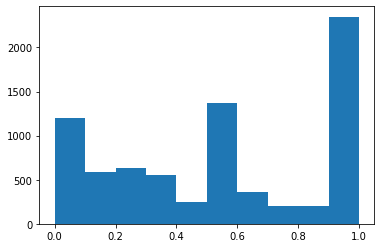

In [ ]:
## BM25 - WIKI TEST Set - 500 document retrieved per query
bm25_wiki_test_eval = {}
bm25_wiki_test_map_unnorm = 0
bm25_wiki_test_map = 0
AP_bm25 = []

number_of_retrieved_docs(bm25_retrieval_wiki_test_docs_scores_dict, bm25_wiki_test_eval)
true_pos(retrieval_ready_qa_wiki_test_dict, bm25_retrieval_wiki_test_docs_scores_dict, bm25_wiki_test_eval)
precision_recall(bm25_wiki_test_eval)
MAP(retrieval_ready_qa_wiki_test_dict, bm25_retrieval_wiki_test_docs_scores_dict ,bm25_wiki_test_eval, bm25_wiki_test_map_unnorm, bm25_wiki_test_map)

check_perf(bm25_wiki_test_eval)
APhistogram(bm25_wiki_test_eval, AP_bm25)

7701

MAP: 0.5438711833938163
For 4077 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (52.94 %)
For 7325 queries out of 7701 at least 1 correct document was retrieved (95.12 %)


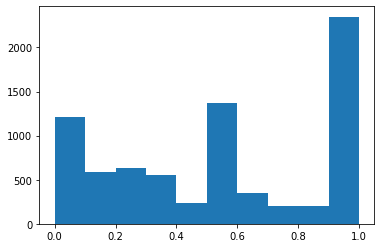

In [ ]:
## BM25 - WIKI TEST Set - 100 document retrieved per query
bm25_wiki_test_eval = {}
bm25_relevant_docs_for_NN = {}
bm25_wiki_test_map_unnorm = 0
bm25_wiki_test_map = 0
AP_bm25 = []

number_of_retrieved_docs(top_100_bm25, bm25_wiki_test_eval)
true_pos_NN(retrieval_ready_qa_wiki_test_dict, top_100_bm25, bm25_wiki_test_eval, bm25_relevant_docs_for_NN)
precision_recall(bm25_wiki_test_eval)
MAP(retrieval_ready_qa_wiki_test_dict, top_100_bm25 ,bm25_wiki_test_eval, bm25_wiki_test_map_unnorm, bm25_wiki_test_map)

#print(list(bm25_wiki_test_eval.items())[:10])
check_perf(bm25_wiki_test_eval)
APhistogram(bm25_wiki_test_eval, AP_bm25)
#AP_bm25
#bm25_relevant_docs_for_NN


MAP: 0.5427824388731309
For 4077 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (52.94 %)
For 7155 queries out of 7701 at least 1 correct document was retrieved (92.91 %)


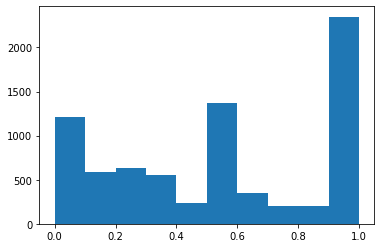

In [ ]:
## BM25 - WIKI TEST Set - 50 document retrieved per query
bm25_wiki_test_eval_50 = {}
bm25_relevant_docs_for_NN = {}
bm25_wiki_test_map_unnorm = 0
bm25_wiki_test_map = 0
AP_bm25_50 = []

number_of_retrieved_docs(top_50_bm25, bm25_wiki_test_eval_50)
true_pos_NN(retrieval_ready_qa_wiki_test_dict, top_50_bm25, bm25_wiki_test_eval_50, bm25_relevant_docs_for_NN)
precision_recall(bm25_wiki_test_eval_50)
MAP(retrieval_ready_qa_wiki_test_dict, top_50_bm25 ,bm25_wiki_test_eval_50, bm25_wiki_test_map_unnorm, bm25_wiki_test_map)

#print(list(bm25_wiki_test_eval_50.items())[:10])
check_perf(bm25_wiki_test_eval_50)
APhistogram(bm25_wiki_test_eval_50, AP_bm25_50)
#AP_bm25_50
#bm25_relevant_docs_for_NN

#save_as_pickle(bm25_relevant_docs_for_NN,bm25_retrieved_docs_TP_FP)



MAP: 0.6031275711952625
For 57 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (57.0 %)
For 94 queries out of 100 at least 1 correct document was retrieved (94.0 %)


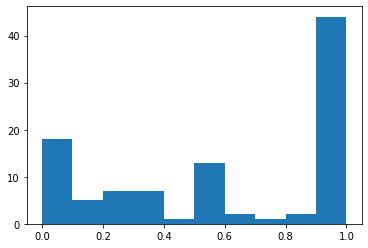

In [ ]:
## BM25 - WIKI TEST Set - 50 document retrieved per query - Comparable for NEURAL - TOP 100 queries only
bm25_wiki_test_eval_50_FNN = {}
bm25_relevant_docs_for_NN = {}
bm25_wiki_test_map_unnorm_FNN = 0
bm25_wiki_test_map_FNN = 0
AP_bm25_50_FNN = []

FOR_NN = {}
counter = 0
for key, items in top_50_bm25.items():
  if counter < 100:
    FOR_NN[key]=items
    counter +=1
  else:
    break 


number_of_retrieved_docs(FOR_NN, bm25_wiki_test_eval_50_FNN)
true_pos_NN(retrieval_ready_qa_wiki_test_dict, FOR_NN, bm25_wiki_test_eval_50_FNN, bm25_relevant_docs_for_NN)
precision_recall(bm25_wiki_test_eval_50_FNN)
MAP(retrieval_ready_qa_wiki_test_dict, FOR_NN ,bm25_wiki_test_eval_50_FNN, bm25_wiki_test_map_unnorm_FNN, bm25_wiki_test_map_FNN)

#print(list(bm25_wiki_test_eval_50_FNN.items())[:10])
check_perf(bm25_wiki_test_eval_50_FNN)
APhistogram(bm25_wiki_test_eval_50_FNN, AP_bm25_50_FNN)
#AP_bm25_50_FNN
#bm25_relevant_docs_for_NN

#save_as_pickle(bm25_relevant_docs_for_NN,bm25_retrieved_docs_TP_FP)



MAP: 0.2515279505607955
For 1554 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (20.18 %)
For 7282 queries out of 7701 at least 1 correct document was retrieved (94.56 %)


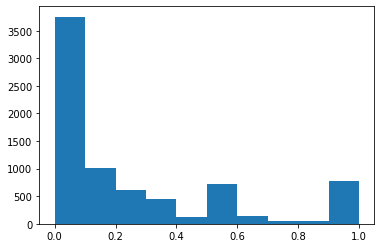

In [ ]:
## VSM - WIKI TEST Set - 500 documents retreived per query
vsm_wiki_test_eval = {}
vsm_wiki_test_map_unnorm = 0
vsm_wiki_test_map = 0
AP_vsm = []

number_of_retrieved_docs(vsm_retrieval_wiki_test_docs_scores_dict, vsm_wiki_test_eval)
true_pos(retrieval_ready_qa_wiki_test_dict, vsm_retrieval_wiki_test_docs_scores_dict, vsm_wiki_test_eval)
precision_recall(vsm_wiki_test_eval)
MAP(retrieval_ready_qa_wiki_test_dict, vsm_retrieval_wiki_test_docs_scores_dict ,vsm_wiki_test_eval, vsm_wiki_test_map_unnorm, vsm_wiki_test_map)

#print(list(vsm_wiki_test_eval.items())[:10])
check_perf(vsm_wiki_test_eval)
APhistogram(vsm_wiki_test_eval, AP_vsm)

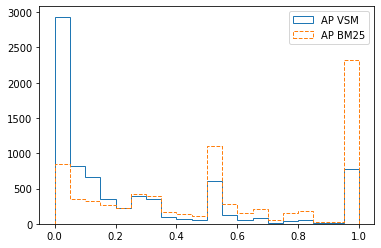

In [ ]:
ComboHist(AP_vsm, AP_bm25)

In [ ]:
# Retrieved Documents: Wiki Test Set(Preprocessed)
bm25_retrieval_wiki_test_docs_scores_dict = None

# Retrieved Documents: Wiki Test Set(Preprocessed)
vsm_retrieval_wiki_test_docs_scores_dict = None

### Error Analysis

In [ ]:
preprocessed_qa_wikipedia_test_without_answers = load_pickle(os.path.join(preprocessed_qa_wikipedia_test_without_answers_filename))

documents_dict = load_pickle(wikipedia_evidence_file)

In [ ]:
nothing_found = []
for key in bm25_wiki_test_eval_50_FNN:
  if bm25_wiki_test_eval_50_FNN[key]["AP"]==0:
    nothing_found.append(key)

print(len(nothing_found))

6


In [ ]:
## Analysis #1
print([nothing_found[0]])
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:50]:
  if qa_pair['QuestionId'] in nothing_found[0]:
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])
    break

doc_id = top_50_bm25[nothing_found[0]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - > document with other meaning retrieved. San Giusto is also a district in Trieste, not only the airport of Pisa. Document contained term airport also multiple times. -> unavoidable

['tc_62']
San Giusto international airport is in which county?
san giusto intern airport counti
Pisa_International_Airport.txt
Trieste.txt


'Trieste (;  ) (, ) is a city and seaport in northeastern Italy. It is situated towards the end of a narrow strip of Italian territory lying between the Adriatic Sea and Slovenia, which lies almost immediately south and east of the city. It is also located near Croatia some further 30 km south. Trieste is located at the head of the Gulf of Trieste and throughout history it has been influenced by its location at the crossroads of Latin, Slavic, and Germanic cultures. In 2009, it had a population of about 205,000  and it is the capital of the autonomous region Friuli-Venezia Giulia and the Province of Trieste.  Trieste was one of the oldest parts of the Habsburg Monarchy. In the 19th century, it was the most important port of one of the Great Powers of Europe. As a prosperous seaport in the Mediterranean region, Trieste became the fourth largest city of the Austro-Hungarian Empire (after Vienna, Budapest, and Prague). In the fin-de-siècle period, it emerged as an important hub for litera

In [ ]:
print([nothing_found[1]])
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:50]:
  if qa_pair['QuestionId'] in nothing_found[1]:
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])
    break

doc_id = top_50_bm25[nothing_found[1]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

['tc_281']
Which Chinese year follows the year of the sheep?
chines year follow year sheep
Chinese_calendar.txt
Goat_(zodiac).txt


'The Goat () is the eighth sign of the 12-year cycle of animals that appear in the Chinese zodiac related to the Chinese calendar. The sign is alsoWen Huang, [http://articles.chicagotribune.com/2003-01-31/entertainment/0301310448_1 "Year of the Sheep, Goat or Ram?"] Chicago Tribune, January 31, 2003. Retrieved 8 February 2015. referred to as the Ram or Sheep sign,  since the Chinese word yáng is more accurately translated as Caprinae, a taxonomic subfamily which includes both sheep and goats.   The Year of the Goat (alternatively, Year of the Ram or Year of the Sheep) is associated with the 8th Earthly Branch symbol, 未 (wèi).   Goat or Sheep  The Chinese word yáng refers both to goats and sheep,  with shānyáng specifically goats and miányáng sheep.   In English, the sign (originally based on a horned animal) may be called either.  The interpretation of sheep or goat depends on culture.  In Vietnamese, the sign is mùi, which is unambiguously goat.[http://www.cjvlang.com/Spicks/sheepgoat

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:50]:
  if qa_pair['QuestionId'] in nothing_found[2]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])
    break

doc_id = top_50_bm25[nothing_found[2]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_436
The name of God is not mentioned in only one book of the Bible. Which one?
name god mention one book bibl one
Bible.txt
Samuel.txt


'Samuel (;  ; Arabic:  Ṣamuil;  Samouēl; ; Strong\'s: Shemuwel), literally meaning "Name of God" in Hebrew, is a leader of ancient Israel in the Books of Samuel in the Hebrew Bible. He is also known as a prophet and is mentioned in the second chapter of the Qur\'an, although not by name.   His status, as viewed by rabbinical literature, is that he was the last of the Hebrew Judges and the first of the major prophets who began to prophesy inside the Land of Israel. He was thus at the cusp between two eras. According to the text of the Books of Samuel, he also anointed the first two kings of the Kingdom of Israel: Saul and David.  Biblical account  Family  Samuel\'s mother was Hannah and his father was Elkanah. Elkanah lived at Rama-thaim in the district of Zuph.[http://oca.org/saints/lives/2015/08/20/102349-prophet-samuel "Prophet Samuel" Orthodox Church in America] His genealogy is also found in a pedigree of the Kohathites (1 Chron. 6:3-15) and in that of Heman, his great-grandson (ib

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:50]:
  if qa_pair['QuestionId'] in nothing_found[3]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])

doc_id = top_50_bm25[nothing_found[3]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_644
Who was the first British Prime Minister to be born overseas?
first british prime minist bear oversea
Prime_Minister_of_the_United_Kingdom.txt
Patricia_Scotland,_Baroness_Scotland_of_Asthal.txt


'Patricia Janet Scotland, Baroness Scotland of Asthal, PC, QC (born 19 August 1955) is a British barrister who served in junior ministerial positions within the UK Government, most notably as the  Attorney General for England and Wales and Advocate General for Northern Ireland. At the 2015 Commonwealth Heads of Government Meeting she was elected the 6th Secretary-General of the Commonwealth of Nations and took office on April 1, 2016. She is the first woman to hold the post. She is a dual citizen of the United Kingdom and Dominica.  Early life and career  Scotland was born in Dominica, the 10th child of 12 born to Roman Catholic parents  a Dominican mother and Antiguan father.[http://www.afr.com/brand/rear-window/alexander-downer-narrowly-avoids-commonwealth-secretarygeneral-job-20151129-glanqm Her family emigrated to Walthamstow when she was two years old, where she attended Walthamstow School for Girls. She then went on to Mid Essex Technical College in Chelmsford, where she obtained

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:500]:
  if qa_pair['QuestionId'] in nothing_found[4]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])


doc_id = top_50_bm25[nothing_found[4]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_969
What star sign was Michael Jackson?
star sign michael jackson
Astrological_sign.txt
Jackie_Jackson.txt


'Sigmund Esco "Jackie" Jackson (born May 4, 1951) is an American singer and musician notable for being a member of The Jackson 5. He is the second child of the Jackson family and the oldest Jackson brother.  Early life  Sigmund Esco Jackson was born on his mother Katherine\'s 21st birthday in 1951. Nicknamed Jackie by his grandfather, taken from Jackson Boy, he came from an African-American working-class family. He and his brothers and sisters grew up in a three-room house in Gary, Indiana, an industrial city outside of Chicago. In 1964, Jackie\'s father, Joseph, formed the Jackson Brothers singing group, which included Jackie and his brothers Tito and Jermaine. The group included younger brothers Marlon and Michael playing assorted percussive instruments. By 1966, Joseph made Michael the lead singer and within two years, they emerged professionally under the name The Jackson Five, which was later altered to a numeral 5 after signing with Motown in 1969.  Prior to the group signing wit

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:500]:
  if qa_pair['QuestionId'] in nothing_found[5]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])


doc_id = top_50_bm25[nothing_found[5]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_1278
Who was dubbed The Lone Eagle?
dub lone eagl
Charles_Lindbergh.txt
List_of_The_Hobbit_characters.txt


'This article describes all named characters appearing in The Hobbit. Creatures as collectives are not included. Characters are categorized by race. Spelling and point of view are given as from The Hobbit; details from sources outside The Hobbit are given only where important to understanding the character within the tale, and with the source explicitly noted.  Hobbits  * Bilbo Baggins of Bag End, the protagonist and titular hobbit of the story. * Bungo Baggins, Bilbo\'s father. * Belladonna Took, Bilbo\'s mother. * The Old Took, Bilbo\'s maternal grandfather. * Chubb, Chubb, and Burrowes, auctioneers managing the liquidation of Bilbo’s effects. * The Sackville-Bagginses, “cousins” to Bilbo. They arranged an auction to dispose of Bilbo’s effects long after he disappeared. Bilbo returned during the auction, upsetting the plans the Sackville-Bagginses had for moving into his fine hobbit hole. Bilbo suspected them of making off with some of his silver spoons. * Bullroarer Took, a historic

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:500]:
  if qa_pair['QuestionId'] in nothing_found[6]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])


doc_id = top_50_bm25[nothing_found[6]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_1526
Where were the last Olympics of the 20th century in the USA held?
last olymp 20th centuri usa hold
Olympic_Games.txt
110_metres_hurdles.txt


"The 110 metres hurdles, or 110-meter hurdles, is a hurdling track and field event for men. It is included in the athletics programme at the Summer Olympic Games. The female counterpart is the 100 metres hurdles. As part of a racing event, ten hurdles of 1.067\xa0metres (3.5\xa0ft or 42\xa0inches) in height are evenly spaced along a straight course of 110\xa0metres. They are positioned so that they will fall over if bumped into by the runner. Fallen hurdles do not carry a fixed time penalty for the runners, but they have a significant pull-over weight which slows down the run. Like the 100 metres sprint, the 110\xa0metres hurdles begins in the starting blocks.  For the 110\xa0m hurdles, the first hurdle is placed after a run-up of 13.72\xa0metres (45\xa0ft) from the starting line. The next nine hurdles are set at a distance of 9.14\xa0metres (30\xa0ft) from each other, and the home stretch from the last hurdle to the finish line is 14.02\xa0metres (46\xa0ft) long.  The Olympic Games ha

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:500]:
  if qa_pair['QuestionId'] in nothing_found[7]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])


doc_id = top_50_bm25[nothing_found[7]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_1504
Who led the US team to Davis Cup championships in 1968,1969,and 1970?
lead us team davi cup championship 1968 1969 1970
The_Championships,_Wimbledon.txt
Rod_Laver.txt


'Rodney George "Rod" Laver  (born 9 August 1938) is an Australian former tennis player widely regarded as one of the greatest in tennis history. He was the No. 1 ranked professional from 1964 to 1970, spanning four years before and three years after the start of the Open Era. He also was the No. 1 amateur in 1961–62 according to Lance Tingay.  Laver\'s 200 singles titles are the most in tennis history, and he holds the all-time male singles records of 22 titles in a single season (1962) and seven consecutive years (1964–70) winning at least 10 titles per season. He excelled on all of the court surfaces of his time: grass, clay, hard, carpet, and wood/parquet.  Despite being banned from playing the Grand Slam tournaments for the five years prior to the Open Era, he still won 11 singles titles. He is the only player to twice achieve the calendar-year Grand Slam, in 1962 and 1969, and remains the only man to do so during the Open Era. He also won eight Pro Slam titles, including the calen

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:500]:
  if qa_pair['QuestionId'] in nothing_found[8]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])


doc_id = top_50_bm25[nothing_found[8]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_1641
Who was the only leading member of M*A*S*H to have starred on TV and in the movie?
lead member h star tv movi
M*A*S*H_(TV_series).txt
Harry_Morgan.txt


'Harry Morgan (born Harry Bratsberg,      often spelled Harry Bratsburg;    April 10, 1915\xa0– December 7, 2011) was a prolific American actor and director whose television and film career spanned six decades. Morgan\'s major roles included Pete Porter in both December Bride (1954–1959) and Pete and Gladys (1960–1962); Officer Bill Gannon on Dragnet (1967–1970); Gunsmoke (11/23/1970)"The "Witness; Amos Coogan on Hec Ramsey (1972–1974); and for his starring role as Colonel Sherman T. Potter in M*A*S*H (1975–1983) and AfterMASH (1983–1984). Morgan also appeared in more than 100 films.  Early life and career  Morgan was born in Detroit, Michigan, in 1915, the son of Hannah and Henry Bratsberg, who were of Swedish and Norwegian ancestry.   In his interview with the Archive of American Television, Morgan spelled his Norwegian family surname as "Bratsberg". Many sources, however, including some family records, list the spelling as "Bratsburg". According to one source, when Morgan\'s father 

In [ ]:
for qa_pair in preprocessed_qa_wikipedia_test_without_answers[:500]:
  if qa_pair['QuestionId'] in nothing_found[9]:
    print(qa_pair["QuestionId"])
    print(qa_pair["Question"])
    print(qa_pair ['Question_preprocessed'])
    print(qa_pair["EntityPages"][0]['Filename'])


doc_id = top_50_bm25[nothing_found[9]][0][0]
print(doc_id)
documents_dict[doc_id]

## Reason: Word with multiple meanings - all words of query contained in doc, but question not answered. Too advanced for BM25. 

tc_1638
Where was Running the Halls set?
run hall set
Running_the_Halls.txt
Ryan_Hall_(runner).txt


'Ryan Hall (born October 14, 1982 in Kirkland, Washington)  is a retired American long-distance runner. He won the marathon at the 2008 United States Olympic Trials and placed tenth in the Olympic marathon in Beijing. He holds the U.S. record in the half marathon (59:43).  With his half marathon record time, he became the first U.S. runner to break the one-hour barrier in the event.   High school  Hall came on to the running scene as a high school junior.  He graduated from high school in the same year as Dathan Ritzenhein and Alan Webb, behind whom he finished in the 2000 Foot Locker Cross Country Championships.  Hall was the California state cross country champion during his junior and senior seasons at Big Bear High School. He finished third at the Foot Locker Nationals in Orlando during his senior season, and also set the Mt. SAC course record in 2000.   In track, he was the National Scholastic mile champion in his junior season at 4:06.15,  and was the CIF California State Meet ch

# Neural Retrieval

In [ ]:
# Reranked Top 50 Documents: Wiki Train Set(Preprocessed)
roberta_5k_15k_first = load_pickle(bm25_rr_100_roberta_5000_15000_wd_1)
roberta_5k_15k_rh_second = load_pickle(bm25_rr_100_roberta_5000_15000_wd_2_rh)

bm25_available_docs = load_pickle(bm25_retrieved_docs_TP_FP)


In [ ]:
print(roberta_5k_15k_first['tc_7'])
roberta_5k_15k_rh_second['tc_7']

[('Asmara.txt', 0.9986739158630371), ('Asmara_International_Airport.txt', 0.9986680746078491), ('International_airport.txt', 0.9986637830734253), ('Queen_Alia_International_Airport.txt', 0.9986587762832642), ('O._R._Tambo_International_Airport.txt', 0.9986554384231567), ('Airport.txt', 0.9986535310745239), ('Eritrea.txt', 0.9986521601676941), ('Hartsfield–Jackson_Atlanta_International_Airport.txt', 0.9986442923545837), ('Simón_Bolívar_International_Airport_(Venezuela).txt', 0.9986432194709778), ('Keflavík_International_Airport.txt', 0.9986363053321838), ('Kotoka_International_Airport.txt', 0.9986328482627869), ('Abu_Dhabi_International_Airport.txt', 0.9986327290534973), ('Benina_International_Airport.txt', 0.9986318945884705), ('Ben_Gurion_Airport.txt', 0.9986251592636108), ('Burgas_Airport.txt', 0.9986118078231812), ('Zürich_Airport.txt', 0.9986110925674438), ('Malta_International_Airport.txt', 0.9986044764518738), ('Ted_Stevens_Anchorage_International_Airport.txt', 0.9985719919204712

[('Asmara.txt', 0.9883749485015869),
 ('Asmara_International_Airport.txt', 0.9881917834281921),
 ('International_airport.txt', 0.9840713739395142),
 ('Eritrea.txt', 0.9730979204177856),
 ('Airport.txt', 0.9705140590667725),
 ('Queen_Alia_International_Airport.txt', 0.9347216486930847),
 ('Malta_International_Airport.txt', 0.007529357448220253),
 ('Abu_Dhabi_International_Airport.txt', 0.00690794549882412),
 ('O._R._Tambo_International_Airport.txt', 0.005719476845115423),
 ('Keflavík_International_Airport.txt', 0.004882679786533117),
 ('Benina_International_Airport.txt', 0.00483199767768383),
 ('Ben_Gurion_Airport.txt', 0.0047182729467749596),
 ('Simón_Bolívar_International_Airport_(Venezuela).txt', 0.004314542748034),
 ('East_Africa.txt', 0.004115324933081865),
 ('Zürich_Airport.txt', 0.00409332662820816),
 ('Kotoka_International_Airport.txt', 0.004070845432579517),
 ('Amílcar_Cabral_International_Airport.txt', 0.003943733870983124),
 ('Transport_in_Germany.txt', 0.0037019168958067894)

### First Cycle: 5000 - 15000

Wiki test set


In [ ]:
print("Retrieved:")
print(roberta_5k_15k_first['tc_62'][:10])
print("All relevant documents:")
print(retrieval_ready_qa_wiki_test_dict['tc_62']['matching_documents'])
print("Relevant documents available after BM25 retrieval:")
bm25_available_docs['tc_62']['matching_documents']

Retrieved:
[('Bangor_International_Airport.txt', 0.9986566305160522), ('John_Wayne_Airport.txt', 0.9986500144004822), ('Seattle–Tacoma_International_Airport.txt', 0.9986386895179749), ('Ronald_Reagan_Washington_National_Airport.txt', 0.9986366629600525), ('Bob_Hope_Airport.txt', 0.9986333250999451), ('International_Air_Transport_Association_airport_code.txt', 0.9986230134963989), ('Marin_County,_California.txt', 0.9981731176376343), ('Laredo,_Texas.txt', 0.997865617275238), ('Los_Angeles_County,_California.txt', 0.9978609681129456), ('Tan_Son_Nhat_International_Airport.txt', 0.9977437257766724)]
All relevant documents:
['Pisa_International_Airport.txt']
Relevant documents available after BM25 retrieval:


[]


MAP: 0.7176252155703376
For 65 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (65.0 %)
For 94 queries out of 100 at least 1 correct document was retrieved (94.0 %)


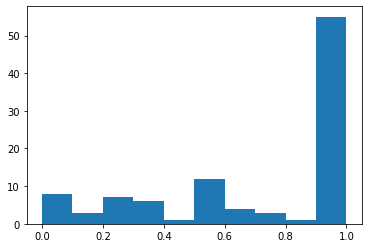

In [ ]:
## WIKI TEST Set
roberta_first_test_eval = {}
roberta_first_test_map_unnorm = 0
roberta_first_test_map = 0
AP_roberta_first = []

number_of_retrieved_docs(roberta_5k_15k_first, roberta_first_test_eval)
true_pos(bm25_available_docs, roberta_5k_15k_first, roberta_first_test_eval)
precision_recall(roberta_first_test_eval)
MAP(bm25_available_docs, roberta_5k_15k_first ,roberta_first_test_eval, roberta_first_test_map_unnorm, roberta_first_test_map)

#print(list(roberta_first_test_eval.items())[:10])
check_perf(roberta_first_test_eval)
#roberta_first_test_eval
APhistogram(roberta_first_test_eval, AP_roberta_first)

### Second Cycle: 5000 - 15000 & random false positive samples

Wiki test set


In [ ]:
print("Retrieved:")
print(roberta_5k_15k_rh_second['tc_37'][:10])
print("All relevant documents:")
print(retrieval_ready_qa_wiki_test_dict['tc_37']['matching_documents'])
print("Relevant documents available after BM25 retrieval:")
bm25_available_docs['tc_37']['matching_documents']

Retrieved:
[('The_Who_concert_disaster.txt', 0.9410664439201355), ('Dayton,_Ohio.txt', 0.006627769209444523), ('Toledo,_Ohio.txt', 0.004680258687585592), ('Declared_death_in_absentia.txt', 0.0038611770141869783), ('George_Voinovich.txt', 0.003767766524106264), ('Ohio_Stadium.txt', 0.0036809826269745827), ('List_of_horse_accidents.txt', 0.0036275440361350775), ('Grateful_Dead.txt', 0.0036100654397159815), ('West_Virginia.txt', 0.0035729713272303343), ('Pulp_(band).txt', 0.0035104737617075443)]
All relevant documents:
['Ohio.txt', 'The_Who_concert_disaster.txt']
Relevant documents available after BM25 retrieval:


['The_Who_concert_disaster.txt']


MAP: 0.7881495485508644
For 73 queries, a correct document was retrieved at rank 1, Precision @Rank 1 = (73.0 %)
For 94 queries out of 100 at least 1 correct document was retrieved (94.0 %)


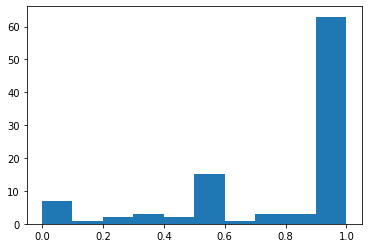

In [ ]:
## WIKI TEST Set
roberta_second_test_eval = {}
roberta_second_test_map_unnorm = 0
roberta_second_test_map = 0
AP_roberta_second = []

number_of_retrieved_docs(roberta_5k_15k_rh_second, roberta_second_test_eval)
true_pos(bm25_available_docs, roberta_5k_15k_rh_second, roberta_second_test_eval)
precision_recall(roberta_second_test_eval)
MAP(bm25_available_docs, roberta_5k_15k_rh_second ,roberta_second_test_eval, roberta_second_test_map_unnorm, roberta_second_test_map)

#print(list(roberta_second_test_eval.items())[:10])
check_perf(roberta_second_test_eval)
#roberta_second_test_eval
APhistogram(roberta_second_test_eval, AP_roberta_second)

### Comparison

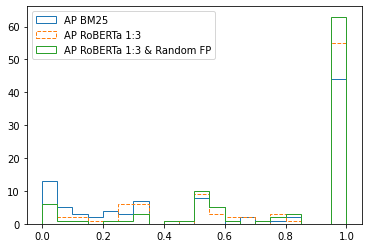

In [ ]:
TripleHist(AP_bm25_50_FNN, AP_roberta_first, AP_roberta_second)